# gensim

[Gensim](https://radimrehurek.com/gensim/) is a topic modeling API. However, gensim also has the ability to create word and document embeddings. Below is a dataset of book titles dealing with two "topics", one for "data science" and the other for "finance". We will use this dataset to see how gensim can be used to learn and recover topics.

In [1]:
import pandas as pd
import numpy as np
import random

np.random.seed(37)
random.seed(37)

df = pd.DataFrame({
    'text': [
        'Data Science from Scratch: First Principles with Python',
        'Data Science for Business: What You Need to Know about Data Mining and Data-Analytic Thinking',
        'Practical Statistics for Data Scientists',
        'Build a Career in Data Science',
        'Python Data Science Handbook',
        'Storytelling with Data: A Data Visualization Guide for Business Professionals',
        'R for Data Science: Import, Tidy, Transform, Visualize, and Model Data',
        'Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control',
        'A Hands-On Introduction to Data Science',
        'Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and The Cloud',
        'How Finance Works: The HBR Guide to Thinking Smart About the Numbers',
        'The Intelligent Investor: The Definitive Book on Value Investing. A Book of Practical Counsel',
        'Introduction to Finance: Markets, Investments, and Financial Management',
        'Python for Finance: Mastering Data-Driven Finance',
        'The Infographic Guide to Personal Finance: A Visual Reference for Everything You Need to Know',
        'Personal Finance For Dummies',
        'Corporate Finance For Dummies',
        'Lords of Finance: The Bankers Who Broke the World',
        'Real Estate Finance & Investments',
        'Real Estate Finance and Investments Risks and Opportunities'
    ],
    'clazz': [1 for _ in range(10)] + [0 for _ in range(10)]
})

df.shape

(20, 2)

We have to tokenize, lemmatize and remove stop words from the original text.

In [2]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english') + list(string.punctuation))

is_valid = lambda t: t not in stop_words
tokenize = lambda t: word_tokenize(t.lower())
lemmatize = lambda t: lemmatizer.lemmatize(t)

df['normalized'] = df.text.apply(lambda text: [lemmatize(t) for t in tokenize(text) if is_valid(t)])
df.shape

(20, 3)

Words that appear only once are removed.

In [3]:
from itertools import chain
import nltk

dist = nltk.FreqDist(list(chain(*df.normalized)))
dist = pd.Series([v for _, v in dist.items()], dist.keys()).sort_values(ascending=False)
dist = dist[dist > 1]
valid_tokens = set(list(dist.index))

df['valid'] = df.normalized.apply(lambda tokens: [t for t in tokens if t in valid_tokens])
df.shape

(20, 4)

## Topic modeling

Now we will apply Latent Semantic Indexing `LSI` and Laten Dirchlet Allocation `LDA` for topic modeling. 

In [4]:
from gensim import corpora

dictionary = corpora.Dictionary(df.valid)
corpus = [dictionary.doc2bow(text) for text in df.valid]

In [5]:
from gensim import models

tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi = lsi_model[corpus_tfidf]

lda_model = models.LdaModel(corpus, id2word=dictionary, iterations=50, num_topics=2)
corpus_lda = lda_model[corpus]

### Visualize document vectors

The LSI and LDA models can transform the documents into vector representation in principal component `PC` or probabilistic space, respectively. We try to visualize the documents in these spaces as a 2D visualization. 

In [6]:
import numpy as np

lsi_data = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
lda_data = np.array([[tup[1] for tup in arr] for arr in corpus_lda])

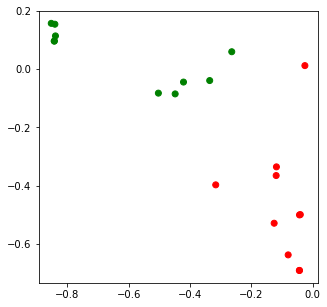

In [7]:
import matplotlib.pyplot as plt

x = lsi_data[:,0]
y = lsi_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

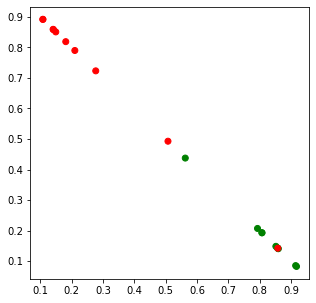

In [8]:
x = lda_data[:,0]
y = lda_data[:,1]
c = ['r' if i == 0 else 'g' for i in df.clazz]

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.scatter(x, y, c=c)

### Print word to topic relevance

The word importances to each topic can also be retrieved.

In [9]:
lsi_model.print_topics()

[(0,
  '-0.641*"data" + -0.572*"science" + -0.412*"python" + -0.165*"learning" + -0.119*"introduction" + -0.109*"business" + -0.100*"data-driven" + -0.080*"finance" + -0.079*"guide" + -0.065*"thinking"'),
 (1,
  '-0.638*"finance" + -0.380*"investment" + -0.312*"real" + -0.312*"estate" + -0.308*"dummy" + -0.200*"personal" + -0.176*"introduction" + -0.145*"guide" + -0.117*"data-driven" + 0.117*"data"')]

In [10]:
lda_model.print_topics()

[(0,
  '0.199*"data" + 0.170*"science" + 0.079*"python" + 0.067*"finance" + 0.047*"practical" + 0.047*"data-driven" + 0.043*"book" + 0.042*"need" + 0.041*"learning" + 0.041*"know"'),
 (1,
  '0.194*"finance" + 0.117*"data" + 0.073*"investment" + 0.067*"guide" + 0.054*"dummy" + 0.053*"estate" + 0.052*"real" + 0.052*"science" + 0.044*"personal" + 0.043*"introduction"')]

### Check coherence

The two coherence measures below are `u_mass` and `c_v`. At a high level, these scores trying to capture how well the words in each topic fit together. Better information about these scores are available at the links following. 

- [How does topic coherence score in LDA intuitively makes sense?](https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense)
- [What is the formula for c_v coherence?](https://stats.stackexchange.com/questions/406216/what-is-the-formula-for-c-v-coherence)

In [11]:
from gensim.models.coherencemodel import CoherenceModel

lsi_cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
lda_cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi -2.5045662415022893
lda -4.4435852671814855


In [12]:
lsi_cm = CoherenceModel(model=lsi_model, texts=df.valid, coherence='c_v')
lda_cm = CoherenceModel(model=lda_model, texts=df.valid, coherence='c_v')

print('lsi', lsi_cm.get_coherence())
print('lda', lda_cm.get_coherence())

lsi 0.5731227064090376
lda 0.5731227064090375


### Check clustering quality

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=37).fit(lsi_data)
score = silhouette_score(lsi_data, kmeans.labels_)
score

0.5873353135960044

In [14]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [15]:
kmeans = KMeans(n_clusters=2, random_state=37).fit(lda_data)
score = silhouette_score(lda_data, kmeans.labels_)
score

0.8070167

In [16]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int32)